In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KernelDensity
from src.utils import load_data, predict_and_plot_SLC
from tqdm import tqdm
from scipy.stats import wasserstein_distance
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [6]:

data = load_data([0,151])

# IMPORTANT: If you want to test the code you can use a small value here and it should run fast
# If you want to reproduce the results in the paper use sample_size=3000
sample_size = 100


In [7]:
# Figure 6

def run(data, sample_size):
    """Generate PDF and CDF data for different distances over time.

    Args:
        data: Input data array
        sample_size: Number of samples to generate

    Returns:
        tuple: (full_res, full_res_cdf) containing PDF and CDF data
    """
    full_res_cdf = []
    full_res = []
    x_time = list(range(0, 150, 2))

    for timestamp in tqdm(x_time):
        Y_result = []
        Y_result_cdf = []

        for distance in range(2, 9):
            # Get predictions for this timestamp and distance
            pred = predict_and_plot_SLC(
                data, timestamp, 600, distance,
                plot=False, sample_size=sample_size, mean_prior=2.872
            )
            mean, var = pred[1]

            # Generate samples from normal distribution
            data_list = []
            for m, v in zip(mean, var):
                data_list += list(np.random.normal(m, np.sqrt(v), size=sample_size))

            # Calculate PDF using kernel density estimation
            X_lin = np.linspace(0, 800, 1000)[:, np.newaxis]
            kde = KernelDensity(kernel='gaussian', bandwidth=1)
            kde.fit(np.array(data_list).reshape((-1, 1)))
            log_density = kde.score_samples(X_lin)
            #print(log_density.shape)
            Y_result.append(np.exp(log_density))

            # Calculate CDF by counting samples above thresholds
            y = []
            for threshold in range(0, 800, 5):
                above_threshold = len([x for x in data_list if x > threshold])
                y.append(above_threshold / len(data_list))
            Y_result_cdf.append(y)

        full_res.append(Y_result)
        full_res_cdf.append(Y_result_cdf)

    return full_res, full_res_cdf

In [8]:

full_res, full_res_cdf = run(data, sample_size)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:56<00:00,  3.16s/it]


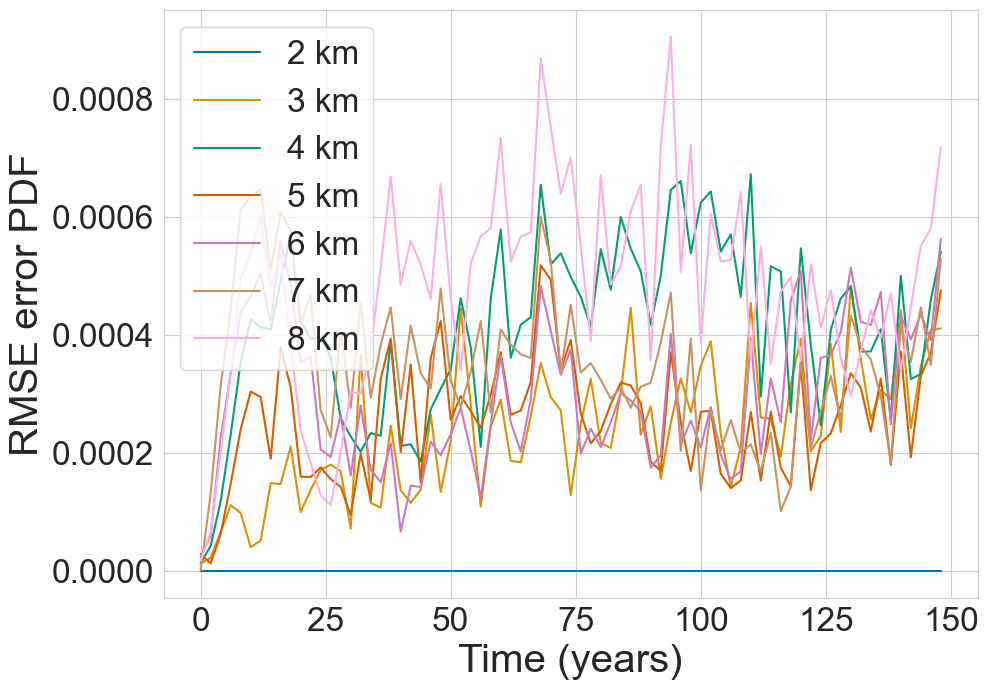

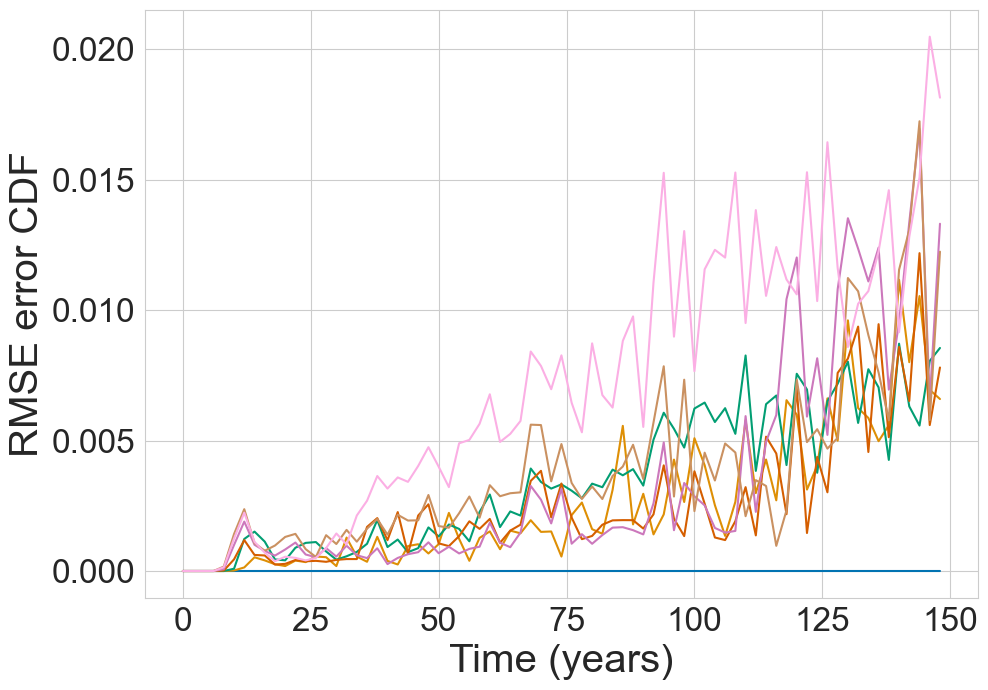

In [9]:
def normalize(x):
    return x / np.array(x).sum()

def calculate_samples(prob_data, i, n):
    """Generate samples using probability distributions"""
    print(len(n))
    samples = np.random.choice(np.linspace(0,800,1000), size=1000, p=normalize(n))
    print(len(prob_data[i][0]))
    samples_2k = np.random.choice(np.linspace(0,800,1000), size=1000, p=normalize(prob_data[i][0]))
    return samples, samples_2k

def calculate_errors(prob_data, full_res):
    """Calculate Wasserstein and RMSE errors"""
    rmse_error = []

    for i in range(len(full_res)):
        rmse_error.append([np.abs(prob_data[i][0] - np.array(n)).mean() for n in prob_data[i]])
    return rmse_error

def plot_error(x_time, err_list, label, density_index):
    """Plot and save error plots"""
    cutoff = 75
    err = np.array(err_list)
    plt.figure(figsize=(10,7))

    for i in range(err.shape[1]):
        plt.plot(x_time[:cutoff], err[:cutoff,i], label=str(range(2,9)[i])+" km")

    if density_index < 1:
        plt.legend(fontsize=24)
    plt.xlabel("Time (years)", fontsize=29)
    plt.ylabel(label, fontsize=29)
    plt.tick_params(axis='both', labelsize=24)
    plt.tight_layout()

    plt.savefig(f"./../assets/plots/fig_6/{label}_error_{density}.pdf", bbox_inches='tight')

# Main execution
x_time = list(range(0,150,2))
for density_index, density in enumerate(["PDF", "CDF"]):
    prob_data = full_res_cdf if density == "CDF" else full_res

    rmse_error = calculate_errors(prob_data, full_res)

    for err_list, label in zip([rmse_error],[f"RMSE error {density}"]):
        plot_error(x_time, err_list, label, density_index)